# Mie Scattering of a Lossless Dielectric Sphere

A common reference calculation in computational electromagnetics for which an analytical solution is known is [Mie scattering](https://en.wikipedia.org/wiki/Mie_scattering) which involves computing the [scattering efficiency](http://www.thermopedia.com/content/956/) of a single, homogeneous sphere given an incident planewave. The scattered power of any object (absorbing or non) can be computed by surrounding it with a *closed* [DFT flux](https://meep.readthedocs.io/en/latest/Python_User_Interface/#flux-spectra) box (its size and orientation are irrelevant because of Poynting's theorem) and performing two simulations: (1) a normalization run involving an empty cell to save the incident fields from the source and (2) the scattering run with the object but first subtracting the incident fields in order to obtain just the scattered fields. This approach has already been described in [Transmittance Spectrum of a Waveguide Bend](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics#transmittance-spectrum-of-a-waveguide-bend).

The scattering cross section is the scattered power in all directions divided by the incident intensity. The scattering efficiency, a dimensionless quantity, is the ratio of the scattering cross section to the cross sectional area of the sphere. In this demonstration, the sphere is a lossless dielectric with wavelength-independent refractive index of 2.0. This way, [subpixel smoothing](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing) can improve accuracy at low resolutions which is important for reducing the size of this 3d simulation. The source is an $E_z$-polarized, planewave pulse (its `size` parameter fills the *entire* cell in 2d) spanning the broadband wavelength spectrum of 10% to 50% the circumference of the sphere. There is one subtlety: since the [planewave source extends into the PML](https://meep.readthedocs.io/en/latest/Perfectly_Matched_Layer/#planewave-sources-extending-into-pml) which surrounds the cell on all sides, `is_integrated=True` must be specified in the source object definition. A `k_point` of zero specifying periodic boundary conditions is necessary in order for the source to be infinitely extended. Also, given the [symmetry of the fields and the structure](https://meep.readthedocs.io/en/latest/Exploiting_Symmetry), two mirror symmery planes can be used to reduce the cell size by a factor of four. The simulation results are validated by comparing with the analytic theory obtained from the [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/) module (which you will have to install in order to run the script below).

In [12]:
import meep as mp
import numpy as np
import json
import csv

# --- Load simulation parameters ---
keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"

def load_params(path=path):
    with open(path, "r") as f:
        return json.load(f)

params = load_params()

# --- Simulation setup ---
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

omega = params["omega"]
resolution = params["resolution"]
frq = omega / (2 * np.pi)
wvl = 1 / frq
pml_layers = [mp.PML(thickness=pml_thickness)]

# --- Load sampling points from CSV ---
def load_probe_points(csv_path):
    points = []
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            x, y, z = map(float, row)
            points.append(mp.Vector3(x, y, z))
    return points

# --- Safe DFT size based on 2D/3D simulation ---
def get_safe_dft_size():
    return mp.Vector3(0.1, 0.1, 0.1 if cell_size.z > 0 else 0)

# --- Add DFT region at point ---
def add_point_dft(sim, pt):
    sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        center=pt,
        size=get_safe_dft_size(),
        fcen=[frq],
        df=0,
        nfreq=1
    )

# --- Define eigenmode UPW source (downward, in -z) ---
def make_eigenmode_source(polarization: str):
    mode_pol = mp.Ey if polarization == "y" else mp.Ex
    return [mp.EigenModeSource(
        src=mp.GaussianSource(frequency=frq, fwidth=1, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 1),
        size=mp.Vector3(cell_size.x, cell_size.y, 0),
        direction=-mp.Z,
        eig_kpoint=mp.Vector3(0, 0, -1),
        eig_match_freq=True,
        eig_parity=mp.ODD_Z if mode_pol == mp.Ex else mp.EVEN_Z,
        component=mode_pol
    )]

# --- Run simulation and collect field data ---
def run_meep_simulation(sources, probe_points):
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3()
    )

    # Single DFT region covering all points
    safe_size = mp.Vector3(
        cell_size.x if cell_size.x > 0 else 1e-6,
        cell_size.y if cell_size.y > 0 else 1e-6,
        cell_size.z if cell_size.z > 0 else 1e-6
    )

    sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        center=mp.Vector3(),
        size=safe_size,
        freq=[frq]        # ✅ THIS WORKS in older Meep versions
    )




    sim.run(until_after_sources=60)

    field_data = []
    for pt in probe_points:
        row = []
        for comp in [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz]:
            val = sim.get_dft_point(comp, pt, frq)  # ← interpolates from full DFT grid
            row.extend([val.real, val.imag])
        field_data.append(row)

    return field_data

# --- Export to CSV ---
def export_complex_fields(field_data, filename):
    header = [
        "Ex_Re", "Ex_Im", "Ey_Re", "Ey_Im", "Ez_Re", "Ez_Im",
        "Hx_Re", "Hx_Im", "Hy_Re", "Hy_Im", "Hz_Re", "Hz_Im"
    ]
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(field_data)
    print(f"Export complete: {filename}")

# --- Main execution ---
print(f"Running Meep eigenmode simulation at frequency = {frq:.4f} ({wvl:.4f} λ)")

probe_points = load_probe_points("PW_testpoints_simple.csv")

# --- X-polarized UPW ---
sources_ex = make_eigenmode_source("x")
field_data_ex = run_meep_simulation(sources_ex, probe_points)
export_complex_fields(field_data_ex, "complex_fields_ex.csv")

# --- Y-polarized UPW ---
sources_ey = make_eigenmode_source("y")
field_data_ey = run_meep_simulation(sources_ey, probe_points)
export_complex_fields(field_data_ey, "complex_fields_ey.csv")


Running Meep eigenmode simulation at frequency = 0.1592 (6.2832 λ)


IndexError: tuple index out of range

In [1]:
from tabulate import tabulate

def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

table_data = [
    [f"{scalar(row['beta']):.1f}°",
     f"{scalar(row['X1']):.5f}",
     f"{scalar(row['X2']):.5f}",
     f"{scalar(row['Y1']):.5f}",
     f"{scalar(row['Y2']):.5f}",
     f"{scalar(row['Z1']):.5f}",
     f"{scalar(row['Z2']):.5f}",
     f"{scalar(row['scatt_total']):.5f}"]
    for row in flux_results
]

headers = ["β (°)", "X1 (−x)", "X2 (+x)", "Y1 (−y)", "Y2 (+y)", "Z1 (−z)", "Z2 (+z)", "Scatt. Total"]
print(tabulate(table_data, headers=headers, tablefmt="github"))


NameError: name 'flux_results' is not defined

In [8]:
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

for entry in flux_results:
    print(f"\n--- β = {scalar(entry['beta']):.1f}° ---")
    print(f"X1 (−x): {scalar(entry['X1']):.5f}")
    print(f"X2 (+x): {scalar(entry['X2']):.5f}")
    print(f"Y1 (−y): {scalar(entry['Y1']):.5f}")
    print(f"Y2 (+y): {scalar(entry['Y2']):.5f}")
    print(f"Z1 (−z): {scalar(entry['Z1']):.5f}")
    print(f"Z2 (+z): {scalar(entry['Z2']):.5f}")
    print(f"Scattered Total: {scalar(entry['scatt_total']):.5f}")



--- β = 0.0° ---
X1 (−x): 0.00000
X2 (+x): -0.00000
Y1 (−y): -0.00000
Y2 (+y): 0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 15.0° ---
X1 (−x): 0.00000
X2 (+x): -0.00000
Y1 (−y): -0.00000
Y2 (+y): 0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 30.0° ---
X1 (−x): 0.00000
X2 (+x): -0.00000
Y1 (−y): -0.00000
Y2 (+y): -0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 45.0° ---
X1 (−x): 0.00000
X2 (+x): 0.00000
Y1 (−y): 0.00000
Y2 (+y): -0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 60.0° ---
X1 (−x): -0.00000
X2 (+x): 0.00000
Y1 (−y): 0.00000
Y2 (+y): -0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 75.0° ---
X1 (−x): -0.00000
X2 (+x): 0.00000
Y1 (−y): 0.00000
Y2 (+y): -0.00000
Z1 (−z): -0.04678
Z2 (+z): -0.04678
Scattered Total: -0.00000

--- β = 90.0° ---
X1 (−x): -0.00000
X2 (+x): 0.00000
Y1 (−y): 0.00000
Y2 (+y): -0.00000
Z1 (−z

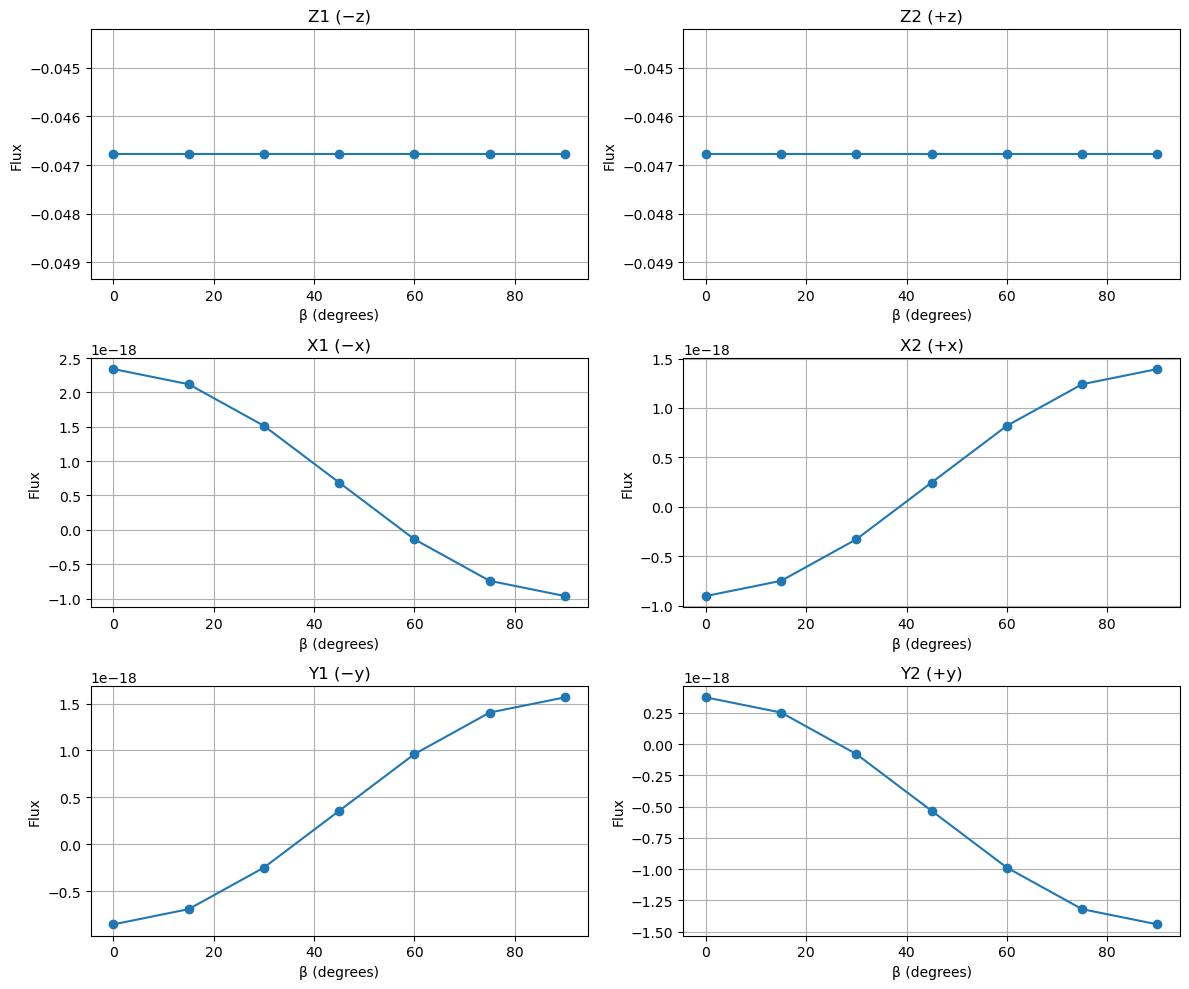

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

# Extract data
betas = [scalar(entry['beta']) for entry in flux_results]
Z1 = [scalar(entry['Z1']) for entry in flux_results]
Z2 = [scalar(entry['Z2']) for entry in flux_results]
X1 = [scalar(entry['X1']) for entry in flux_results]
X2 = [scalar(entry['X2']) for entry in flux_results]
Y1 = [scalar(entry['Y1']) for entry in flux_results]
Y2 = [scalar(entry['Y2']) for entry in flux_results]


# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each component
labels = ['Z1 (−z)', 'Z2 (+z)', 'X1 (−x)', 'X2 (+x)', 'Y1 (−y)', 'Y2 (+y)']
values = [Z1, Z2, X1, X2, Y1, Y2]

for i, (label, val) in enumerate(zip(labels, values)):
    axs[i].plot(betas, val, marker='o')
    axs[i].set_title(label)
    axs[i].set_xlabel("β (degrees)")
    axs[i].set_ylabel("Flux")
    axs[i].grid(True)

# Hide unused subplot if any
if len(axs) > len(labels):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


The incident intensity (`intensity`) is the flux in one of the six monitor planes (the one closest to and facing the planewave source propagating in the $x$ direction) divided by its area. This is why the six sides of the flux box are defined separately. (Otherwise, the entire box could have been defined as a single flux object with different weights ±1 for each side.) The scattered power is multiplied by -1 since it is the *outgoing* power (a positive quantity) rather than the incoming power as defined by the orientation of the flux box. Note that because of the linear $E_z$ polarization of the source, the flux through the $y$ and $z$ planes will *not* be the same. A circularly-polarized source would have produced equal flux in these two monitor planes. The runtime of the scattering run is chosen to be sufficiently long to ensure that the Fourier-transformed fields have [converged](https://meep.readthedocs.io/en/latest/FAQ/checking-convergence).